# Question Answering System using Google's BERT (Guided Project)

### Introduction

As I learn more about Large Language Models (LLMs), I get more and more interested in its different applications. For this guided project, I watched [this video](#https://www.youtube.com/watch?v=l8ZYCvgGu0o) titled **Applying BERT to Question Answering** by ChrisMcCormickAI, where the author demonstrates the application of Bidirectional Encoder Representations from Transformers (BERT) for question-answering. All the code and information in this notebook is taken from Chris's video and colab notebook linked in the video description. My aim here is to follow the steps and 'learn-by-doing' BERT's application in question-answering.  

The data for this project comes [The Standford Question-Answering Dataset](#https://rajpurkar.github.io/SQuAD-explorer/) or SQuAD. The model we will be working with has already been trained and fine-tuned on this data, therefore we do not need to load and train the model ourselves in this project. As Chris explains in the video, the reason for not fine-tuning the BERT model ourselves is because the model has already learned how to do the question-answering from SQuAD benchmark, and will do a good job regardless of the text given to it. For other tasks, such as text classification, it is however a good idea to fine-tune the model on your specific dataset.

### Dependencies

##### Install huggingface 'transformers' library

In [33]:
!pip install transformers

We will be using PyTorch framework. 

In [34]:
!pip install torch

In [35]:
import torch

##### Load pre-trained and fine-tuned BERT model

In [36]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Load the BERT Tokanizer 

In [37]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

As was explained in the [video](#https://www.youtube.com/watch?v=l8ZYCvgGu0o), when we use BERT for question answering, we provide the model with the question itself and a text containing the answer to that question. The purpose of BERT is then to "highlight" the passage from the text that contains the correct answer. This is represented as picking which tokens mark the start and the end of the passage. To do this, we first need to provide BERT with a question and an answer and second, to tokanize both. 

In [38]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

We apply the tokanizer and concatinate the question and the answer.  

In [39]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 70 tokens.


To feed these into BERT, we need to place a [SEP] token between the question tokens and the answer tokens. 

In [40]:
# BERT only needs the token IDs, but for the purpose of inspecting the
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):

    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')

    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

if id == tokenizer.sep_token_id:
    print('')

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102
bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,012

The above are token IDs for each word in our question and answer texts with the token [SEP] separating them. 

BERT also needs to separate the question from the answer text, which it does with "segment embeddings", one for segment A and one for segment B. "Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the question tokens, and the segment B embedding needs to be added to each of the answer_text tokens" [(link to the colab file)](https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-#scrollTo=zm208EApN16k). In the notebook, Chris indicates that this is handled for us by the transformer library, and all we need to do is specify a '0' or '1' for each token.    

In [41]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

Let's now feed our example into the model.

In [42]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True)

In [43]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(outputs.start_logits)
answer_end = torch.argmax(outputs.end_logits)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


The above is the "highlighted" answer BERT "thinks" is the correct answer to the question: "How many parameters does BERT-large have?" - 340 million parameters. It got it correct! 

In [44]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m"


##### Visualizing Scores

As was mentioned in an earlier section, the BERT model highlights the passage from the text with the correct answer contained in it. In the video, Chris looks at the scores for the tokens in the input. We will do the same and plot the start and end token scores for our input.  

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

In [46]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = outputs.start_logits.detach().numpy().flatten()
e_scores = outputs.end_logits.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


/var/folders/24/myyz9b5j3959wdk0l1ky32z40000gn/T/ipykernel_15119/708656701.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)


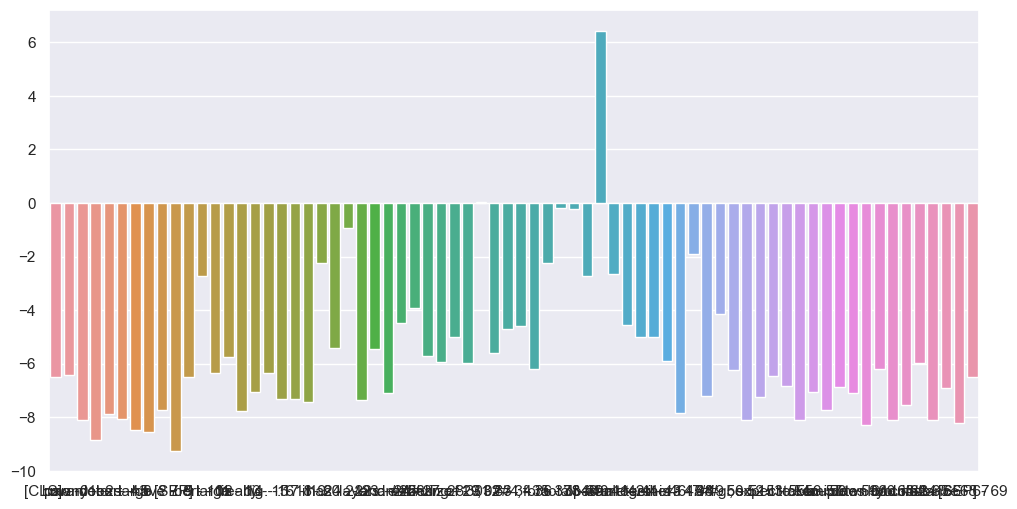

In [47]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

/var/folders/24/myyz9b5j3959wdk0l1ky32z40000gn/T/ipykernel_15119/766807142.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)


[Text(0, 0, '[CLS] -  0'),
 Text(1, 0, 'how -  1'),
 Text(2, 0, 'many -  2'),
 Text(3, 0, 'parameters -  3'),
 Text(4, 0, 'does -  4'),
 Text(5, 0, 'bert -  5'),
 Text(6, 0, '- -  6'),
 Text(7, 0, 'large -  7'),
 Text(8, 0, 'have -  8'),
 Text(9, 0, '? -  9'),
 Text(10, 0, '[SEP] - 10'),
 Text(11, 0, 'bert - 11'),
 Text(12, 0, '- - 12'),
 Text(13, 0, 'large - 13'),
 Text(14, 0, 'is - 14'),
 Text(15, 0, 'really - 15'),
 Text(16, 0, 'big - 16'),
 Text(17, 0, '. - 17'),
 Text(18, 0, '. - 18'),
 Text(19, 0, '. - 19'),
 Text(20, 0, 'it - 20'),
 Text(21, 0, 'has - 21'),
 Text(22, 0, '24 - 22'),
 Text(23, 0, '- - 23'),
 Text(24, 0, 'layers - 24'),
 Text(25, 0, 'and - 25'),
 Text(26, 0, 'an - 26'),
 Text(27, 0, 'em - 27'),
 Text(28, 0, '##bed - 28'),
 Text(29, 0, '##ding - 29'),
 Text(30, 0, 'size - 30'),
 Text(31, 0, 'of - 31'),
 Text(32, 0, '1 - 32'),
 Text(33, 0, ', - 33'),
 Text(34, 0, '02 - 34'),
 Text(35, 0, '##4 - 35'),
 Text(36, 0, ', - 36'),
 Text(37, 0, 'for - 37'),
 Text(38, 0, 'a -

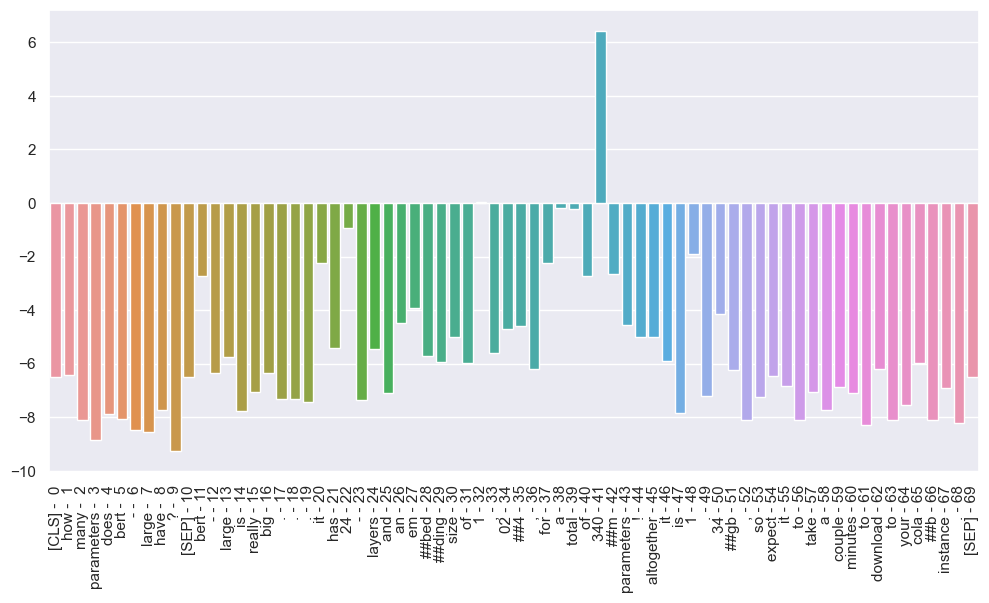

In [48]:
# Turn the xlabels vertical.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

Looking at the plot above, the BERT model is quite confident that the start token for the correct answer is `340`. 

/var/folders/24/myyz9b5j3959wdk0l1ky32z40000gn/T/ipykernel_15119/1502608945.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)


[Text(0, 0, '[CLS] -  0'),
 Text(1, 0, 'how -  1'),
 Text(2, 0, 'many -  2'),
 Text(3, 0, 'parameters -  3'),
 Text(4, 0, 'does -  4'),
 Text(5, 0, 'bert -  5'),
 Text(6, 0, '- -  6'),
 Text(7, 0, 'large -  7'),
 Text(8, 0, 'have -  8'),
 Text(9, 0, '? -  9'),
 Text(10, 0, '[SEP] - 10'),
 Text(11, 0, 'bert - 11'),
 Text(12, 0, '- - 12'),
 Text(13, 0, 'large - 13'),
 Text(14, 0, 'is - 14'),
 Text(15, 0, 'really - 15'),
 Text(16, 0, 'big - 16'),
 Text(17, 0, '. - 17'),
 Text(18, 0, '. - 18'),
 Text(19, 0, '. - 19'),
 Text(20, 0, 'it - 20'),
 Text(21, 0, 'has - 21'),
 Text(22, 0, '24 - 22'),
 Text(23, 0, '- - 23'),
 Text(24, 0, 'layers - 24'),
 Text(25, 0, 'and - 25'),
 Text(26, 0, 'an - 26'),
 Text(27, 0, 'em - 27'),
 Text(28, 0, '##bed - 28'),
 Text(29, 0, '##ding - 29'),
 Text(30, 0, 'size - 30'),
 Text(31, 0, 'of - 31'),
 Text(32, 0, '1 - 32'),
 Text(33, 0, ', - 33'),
 Text(34, 0, '02 - 34'),
 Text(35, 0, '##4 - 35'),
 Text(36, 0, ', - 36'),
 Text(37, 0, 'for - 37'),
 Text(38, 0, 'a -

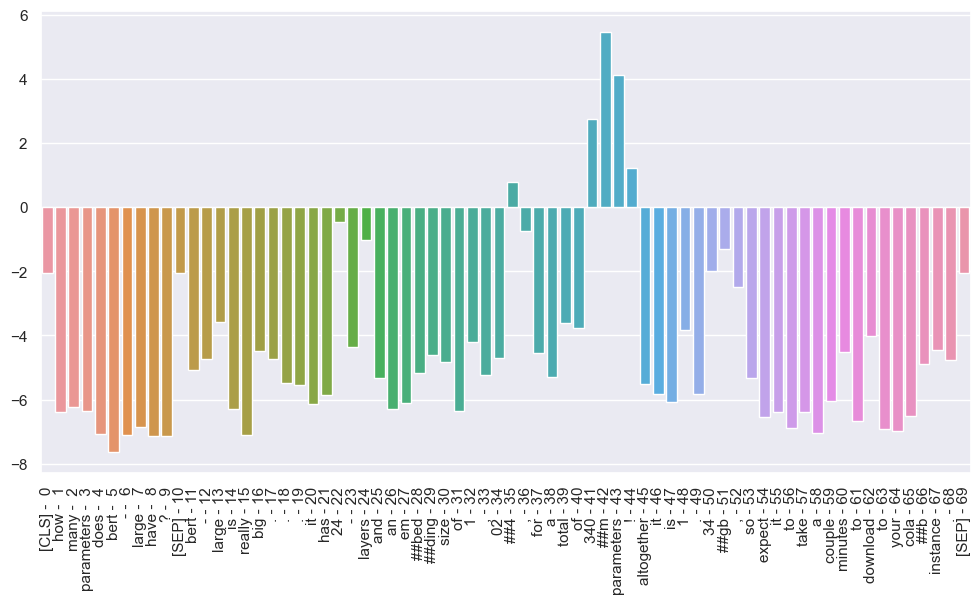

In [49]:
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

With the end token, it is more vague but still picks up the correct words to include in the answer including `340`, `##m` and `parameters`.  

Now let's recreate everything with a function to try other text. 

In [50]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

I will be using the same text that Chris uses in the video, the original abstract from the BERT paper. 

In [51]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models, BERT is designed to pre-train deep bidirectional
representations from unlabeled text by jointly conditioning on both left and
right context in all layers. As a result, the pre-trained BERT model can be
finetuned with just one additional output layer to create state-of-the-art
models for a wide range of tasks, such as question answering and language
inference, without substantial task-specific architecture modifications. BERT is
conceptually simple and empirically powerful. It obtains new state-of-the-art
results on eleven natural language processing tasks, including pushing the GLUE
score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7%
(4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5
point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point a

Now let's ask BERT some questions from the text.

In [52]:
question = "What is the acronym for Bidirectional Encoder Representations from Transformers?"

answer_question(question, bert_abstract)

Query has 244 tokens.

Answer: "bert"


In [53]:
question = "What can I use you for?"

answer_question(question, bert_abstract)

Query has 235 tokens.

Answer: "question answering and language inference"


Wow! It is working! Now to check whether the model performs on any text, I will feed it the profile from my resume and ask it questions about my experience. 

In [54]:
diana_resume = 'Diana is a recent graduate of the Data Science program at BrainStation, where she gained comprehensive practical experience working with relational databases such as MySQL and data visualisation tools such as Tableau. She also posses practical experience training, optimizing and evaluating machine learning algirithms. In November 2023, Diana obtained the industry-leading technical certification, AWS Certified Machine Learning Specialty. She holds a Bachelors Degree with High Distinction in Criminology and Criminal Justice from Carleton University with three years of experience in the criminal justice field. Diana has a proven track record of developing strong relationships and being a collaborative team player. She possesses excellent written and verbal communication skills, being able to tailor messages to different audiences.'

print(wrapper.fill(diana_resume))

Diana is a recent graduate of the Data Science program at BrainStation, where
she gained comprehensive practical experience working with relational databases
such as MySQL and data visualisation tools such as Tableau. She also posses
practical experience training, optimizing and evaluating machine learning
algirithms. In November 2023, Diana obtained the industry-leading technical
certification, AWS Certified Machine Learning Specialty. She holds a Bachelors
Degree with High Distinction in Criminology and Criminal Justice from Carleton
University with three years of experience in the criminal justice field. Diana
has a proven track record of developing strong relationships and being a
collaborative team player. She possesses excellent written and verbal
communication skills, being able to tailor messages to different audiences.


In [55]:
question = "What is Diana's education?"

answer_question(question, diana_resume)

Query has 156 tokens.

Answer: "bachelors degree with high distinction in criminology and criminal justice"


In [56]:
question = "What is Diana's experience?"

answer_question(question, diana_resume)

Query has 156 tokens.

Answer: "three years of experience in the criminal justice field"


In [57]:
question = "What university did she attend?"

answer_question(question, diana_resume)

Query has 155 tokens.

Answer: "carleton university"


In [58]:
question = "How many years of experience does she have?"

answer_question(question, diana_resume)

Query has 158 tokens.

Answer: "three"


It works! Our BERT model has done a pretty impressive job considering that two texts we feed it are quite different. 